# Introduction to scalable computing with Dask

---

## What is Dask?

A library for **parallel and distributed computing in Python**.

Traditionally PyData libraries were designed for linear workflows (for example NumPy, pandas, scikit-learn), Dask provides a similar API to run the same computations in parallel.

### Parallel computing

Computing parts of a workflow simultaneously. Typically, we use this term to describe single-machine parallelism, where your computation can be run simultaneously on various cores while sharing the same memory (RAM).

In [1]:
from time import sleep

def add(x, y):
    sleep(1)
    return x + y

def mul(x, y):
    sleep(1)
    return x * y

In [2]:
%%time

a = add(5, 5)
b = add(10, 10)
c = mul(a, b)
c

CPU times: user 2.11 ms, sys: 1.06 ms, total: 3.17 ms
Wall time: 3 s


200

Think about what in the about workflow can be executed in parallel.

In [3]:
import dask

parallel_add = dask.delayed(add)
parallel_mul = dask.delayed(mul)

In [4]:
%%time

a = parallel_add(5, 5)
b = parallel_add(10, 10)
c = parallel_mul(a, b)
c

CPU times: user 893 µs, sys: 11 µs, total: 904 µs
Wall time: 674 µs


Delayed('mul-7322d771-70f9-4a77-8583-1694c1306ba5')

### Lazy evaluation

Dask evaluates your computations lazily, this is what allows Dask to "scale" your computations.

Dask only creates the "logic" of your computation eagerly, i.e., what are the independent tasks that can be executed in parallel, what does that dependency tree (called "task graph" in Dask) look like.

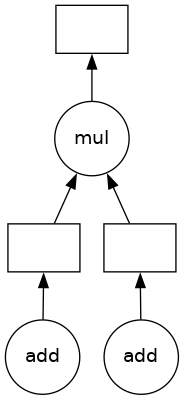

In [5]:
c.visualize()

And, executes the logic on when needed.

In [6]:
%%time

c.compute()

CPU times: user 6.4 ms, sys: 2.47 ms, total: 8.88 ms
Wall time: 2.01 s


200

## Dask DataFrame API

Dask has a few different APIs to parallelize different tools/activities. We will primarily cover Dask's DataFrame API, which parallelizes pandas, in this tutorial.

The idea is to provide a familiar interface to pandas, but leverage parallelism under-the-hood.

In [7]:
import dask.dataframe as dd

In [8]:
ddf = dd.read_csv("gcs://quansight-datasets/airline-ontime-performance/csv/*2022.csv")

In [9]:
ddf

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
npartitions=33,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,object,object,int64,object,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,int64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

We see Dask's lazy evaluation in action again.

Dask has loaded only the metadata information, but none of the actual values.

Besides `.compute()`, some commands like `.head()` also trigger an internal compute.

In [10]:
ddf.head() # ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

/home/conda/global/ff7244ded4a47c109be6838fe217fb426c05eff28051668afcf28de3b76a1653-20230412-222905-796704-160-pycon2023/lib/python3.10/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+-------------------+---------+----------+
| Column            | Found   | Expected |
+-------------------+---------+----------+
| ARR_DELAY_GROUP   | float64 | int64    |
| ARR_TIME          | float64 | int64    |
| CANCELLATION_CODE | object  | float64  |
| DEP_DELAY_GROUP   | float64 | int64    |
| DEP_TIME          | float64 | int64    |
| DIV1_AIRPORT      | object  | float64  |
| DIV1_TAIL_NUM     | object  | float64  |
| DIV2_AIRPORT      | object  | float64  |
| DIV2_TAIL_NUM     | object  | float64  |
| WHEELS_OFF        | float64 | int64    |
| WHEELS_ON         | float64 | int64    |
+-------------------+---------+----------+

The following columns also raised exceptions on conversion:

- CANCELLATION_CODE
  ValueError("could not convert string to float: 'A'")
- DIV1_AIRPORT
  ValueError("could not convert string to float: 'ATL'")
- DIV1_TAIL_NUM
  ValueError("could not convert string to float: 'N924EV'")
- DIV2_AIRPORT
  ValueError("could not convert string to float: 'SYR'")
- DIV2_TAIL_NUM
  ValueError("could not convert string to float: 'N401YX'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'ARR_DELAY_GROUP': 'float64',
       'ARR_TIME': 'float64',
       'CANCELLATION_CODE': 'object',
       'DEP_DELAY_GROUP': 'float64',
       'DEP_TIME': 'float64',
       'DIV1_AIRPORT': 'object',
       'DIV1_TAIL_NUM': 'object',
       'DIV2_AIRPORT': 'object',
       'DIV2_TAIL_NUM': 'object',
       'WHEELS_OFF': 'float64',
       'WHEELS_ON': 'float64'}

to the call to `read_csv`/`read_table`.

### Specify `dtypes`

The lazy behavior of Dask means it infers the datatypes using minimal information -- for CSV files, Dask uses the first row.

This behavior is different from pandas that loads the entire dataset and then infers dtypes.

It's a good practice to provide explicit dtypes. You can do this with the subset of data we looked at in notebook-01 by exporting the datatype with pandas. we've already prepared the dtypes:

In [11]:
import json

with open('prep/dtypes.json', 'r') as f:
    dtypes = json.load(f)

(Optional: You can take a look at `prep/dtypes.json`)

In [12]:
ddf = dd.read_csv("gcs://quansight-datasets/airline-ontime-performance/csv/*", dtype=dtypes)

In [14]:
ddf.head() # No warnings or errors :)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
0,2003,2,4,1,2,4/1/2003 12:00:00 AM,AA,19805,AA,<NA>,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>
1,2003,2,4,1,2,4/1/2003 12:00:00 AM,AA,19805,AA,<NA>,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>
2,2003,2,4,1,2,4/1/2003 12:00:00 AM,AA,19805,AA,<NA>,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>
3,2003,2,4,1,2,4/1/2003 12:00:00 AM,AA,19805,AA,<NA>,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>
4,2003,2,4,1,2,4/1/2003 12:00:00 AM,AA,19805,AA,<NA>,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>


### Partitions

Internally, Dask DataFrame is a collection of pandas DataFrames (these are actual pandas DataFrames internally as well!):

<img src="./images/dask-dataframe.svg" width="30%"/>

where each pandas DataFrame is called a "partition".

Your Dask computations will be run on all the individual pandas DataFrames in parallel, and then combined as necessary.

In [15]:
ddf.npartitions

624

Since we read a CSV file with one month of data per file, our Dask DataFrame is partitions such that each partition corresponds to one file.

In [16]:
ddf.partitions[1]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int16,int8,int8,int8,int8,string,string,int16,string,string,int16,int32,int32,int32,string,string,string,int8,string,int8,int32,int32,int32,string,string,string,int8,string,int8,string,string,float64,float64,float64,float64,string,float64,string,string,float64,string,string,float64,float64,float64,float64,string,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,string,float64,float64,string,string,string,float64,float64,string,float64,float64,string,string,string,float64,float64,string,float64,float64,string,string,string,float64,float64,string,float64,float64,string,string,string,float64,float64,string,float64,float64,string,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Distributed computing

We can also leverage parallel computation on several different machines (workers) with their own processors and memory. The different machines can interact to share data, and a central machine (scheduler) manages all the interactions. We call this process distributed computing.

These different machines can be located anywhere, on your local in-house network or in data centers around the world.

<img src="images/distributed-overview.png" width="50%"/>

## Dask Gateway

Dask Gateway is a library to manage Dask clusters on the cloud.

<img src="images/gateway-architecture.svg" width="50%" />

In [ ]:
import dask_gateway

Create a new Gateway instance:

In [ ]:
gateway = dask_gateway.Gateway()

Set how your workers need to be configured, and make sure the workers have the same environment as your 

In [ ]:
options = gateway.cluster_options(use_local_defaults=False)
options

### Manual vs adaptive scaling

You can specify the exact number of machines required, and Dask will spin all of them up at the beginning. Dask Gateway has a very useful "adaptive scaling" feature. This allows Dask to spin up new machines as your workflow needs it, and then tear them down after the computation.

Adaptive scaling can help manage costs when you have large compute requirements.

Select manual (~5) or adaptive (1-5) below:

In [ ]:
cluster = gateway.new_cluster(options)
cluster

Finally, you can connect this cluster of machines to this IPython notebook using a client:

In [ ]:
client = cluster.get_client()
client

## Dask Dashboard

The Client widget displays a link to a dashboard:
* Click on it, and a new Keycloak sign-up page should open
* Login with the email and password you used to register
* The dashboard opens in the browser window

You will need to login only once, you should be able to access the Dashboard directly if you click on the link next time. :)

You can also access these plots within JupyterLab:
* Click on the Dask logo in the left sidebar
* Click on the magnifying glass icon, the dashboard should connect automatically and display available plots
* Open: Cluster map, task stream, and progress bar

## Quick computation

### Your turn: Compute the longest flight (distance) across the dataset

In [ ]:
# Your code here

In [ ]:
ddf["DISTANCE"].max()
ddf["DISTANCE"].max().compute()

## Ensure cluster shutdown

Idling clusters can quickly add up to costs, so make sure to shutdown your clusters after completing your work.

In [ ]:
cluster.shutdown()
client.close()

---

## Next

[Storage formats](./04-storage-formats.ipynb)!